# ScoreAnalyzer 快速入門使用文件

In [1]:
# Interactive Mode
%pylab inline
interactive(True)

Populating the interactive namespace from numpy and matplotlib


## 定義經常使用的視覺化函式

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 用來顯示圖片
def show(scale=3):
    plt.gcf().set_size_inches(plt.gcf().get_size_inches()*scale)
    plt.gcf().set_dpi(300)
    plt.show()
    plt.gcf().clear()

# 可以在圖片上畫出方塊
def draw_rect(min_c, max_c, style, linewidth=4, ax=None):
    min_x, min_y = min_c
    max_x, max_y = max_c
    
    if ax != None:
        ax.plot([min_x, min_x, max_x, max_x, min_x], [min_y, max_y, max_y, min_y, min_y], style, linewidth=linewidth)
    else:
        plt.plot([min_x, min_x, max_x, max_x, min_x], [min_y, max_y, max_y, min_y, min_y], style, linewidth=linewidth)

## 先選定圖片的路徑

In [3]:
no = 13
path = "../../data/score{:03d}.jpg".format(no)

print "選定的圖片路徑為：\"{}\"".format(path)

選定的圖片路徑為："../../data/score013.jpg"


## 使用 `ScoreAnalyzer.image.imagetools` 來存取圖片

In [4]:
from ScoreAnalyzer.image import imagetools as it

data = it.load(path, thresh=.2, reverse=True)
# it.load(path, thresh, reverse)
#   - path   : 圖片路徑（必須填寫）
#   - thresh : 二元化的閾值，介於0到1之間（選擇性填寫，預設為0.5）
#   - reverse: 黑色像素為1則設定True，反之為False（選擇性填寫，預設為True）

print "變數data是一個{}x{}的矩陣：".format(*data.shape)
print data

變數data是一個1753x1240的矩陣：
[[ 1.  1.  1. ...,  0.  1.  1.]
 [ 1.  1.  1. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  1.  0. ...,  0.  0.  0.]
 [ 1.  1.  0. ...,  0.  0.  0.]
 [ 1.  1.  0. ...,  0.  0.  0.]]


## 顯示讀取的圖片

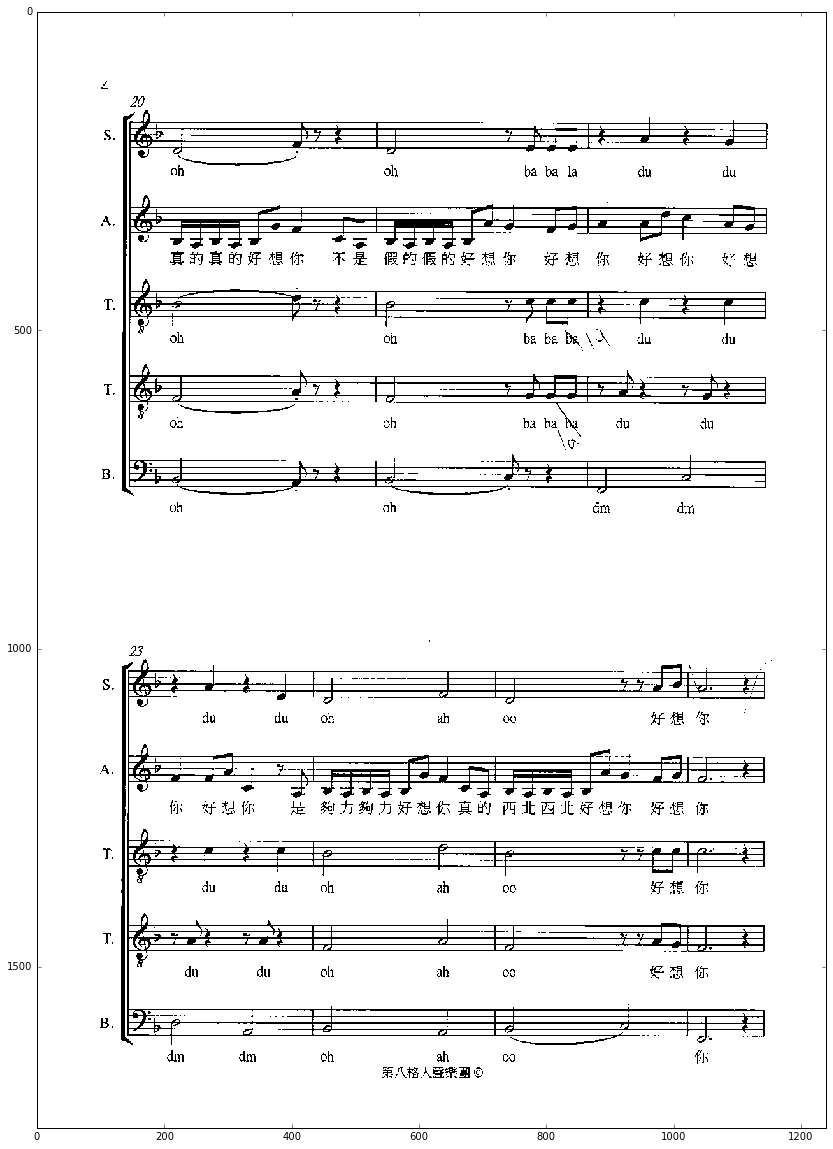

In [5]:
plt.imshow(data, cmap=plt.cm.binary, interpolation="nearest")
show(scale=5)

# 前處理
<p>
前處理涵蓋兩大部分：(1)五線譜的線寬線距估計以及(2)五線譜的線偵測與去除
</p>

## 使用 `ScoreAnalyzer.staffline.stafflineinfo` 來找出線寬、線距以及線的可能位置

There are 7967 possible staff centers.
Thickness: 2, Margin: 8.


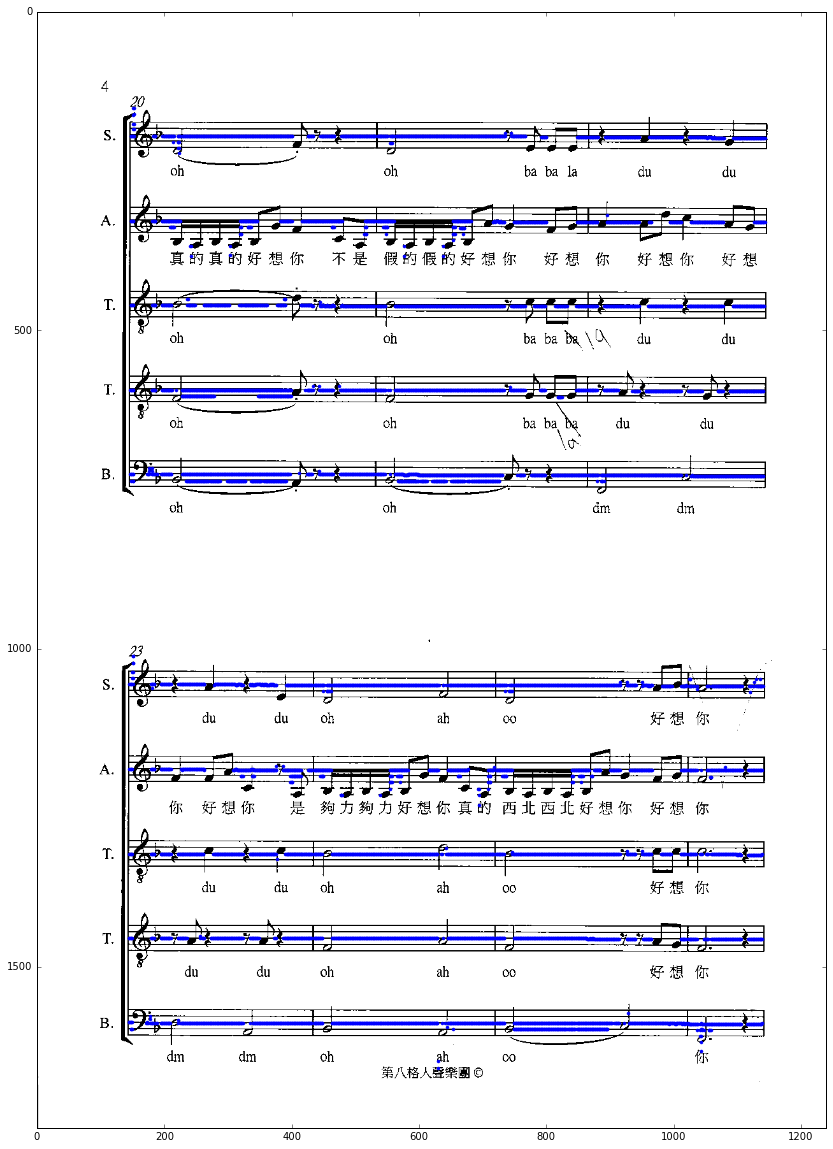

In [6]:
from ScoreAnalyzer.staffline import stafflineinfo as stfinfo

# info: 一個hash結構，keys如下
#   - width  : 線寬（單位為像素）
#   - space  : 線距（單位為像素）
#   - centers: 一個整數陣列的陣列，其中第n個元素表示第n行可能有五線的所有y位置的值
# 附註：這個函式可能會花一點時間（因為進行全域搜尋）
info = stfinfo.staffline_info(data)

# print profiles
print "There are {} possible staff centers.".format(sum(map(lambda x: len(x), info["centers"])))
print "Thickness: {}, Margin: {}.".format(info["width"], info["space"])

# 將五線中心畫出來
for i, c in enumerate(info["centers"]):
    plt.plot([i]*len(c), c, "b.") # 每一個藍點表示一個可能的五線中心

plt.imshow(data, cmap=plt.cm.binary)
show(scale=5)

<p>
有了五線中心的資訊以後，可以進一步偵測五線的中心線，就可以把每一行樂譜定位出來。
</p>

## 使用 `ScoreAnalyzer.linefit.linefinder` 找出五線中心線

In [7]:
from ScoreAnalyzer.linefit import linefinder as lf

height = 5*info["width"] + 4*info["space"] # 五線總高度為五個線寬以及四個線距

# find_lines_by_centers_RANSAC(centers, min_margin, in_thresh, ang_thresh, max_iter, NRANSAC):
#   - centers   : 利用 staffline_info(data) 取得的中心點資訊
#   - in_thresh : 視為同一群體(inliers)的y座標差距閾值
#   - ang_thresh: 五線中心線之間的角度差（單位為弧度），為了要讓找尋到的線之間盡可能平行
#   - max_iter  : 找線的遞迴次數
#   - NRANSAC   : 執行RANSAC的遞迴次數
staff_center_lines = lf.find_lines_by_centers_RANSAC(info["centers"], 
                                             min_margin=height*1.5, 
                                             in_thresh=.2, 
                                             ang_thresh=0.005, 
                                             max_iter=10, 
                                             NRANSAC=200)

# 按照中心線的y截距大小重新排列
staff_center_lines = sorted(staff_center_lines, key=lambda x: x[1])

# 將中心線的方程式印出來
for i, center_line in enumerate(staff_center_lines):
    slope, intercept = center_line
    print "[{:02d}] y = ({:e})x + ({:e})".format(i+1, slope, intercept)

[01] y = (4.566210e-03)x + (1.920822e+02)
[02] y = (-0.000000e+00)x + (3.280000e+02)
[03] y = (3.921569e-03)x + (4.580392e+02)
[04] y = (2.994012e-03)x + (5.920928e+02)
[05] y = (0.000000e+00)x + (7.270000e+02)
[06] y = (0.000000e+00)x + (1.057000e+03)
[07] y = (-0.000000e+00)x + (1.190000e+03)
[08] y = (0.000000e+00)x + (1.323000e+03)
[09] y = (-0.000000e+00)x + (1.455000e+03)
[10] y = (-0.000000e+00)x + (1.588000e+03)


## 接著將偵測到的線畫出來

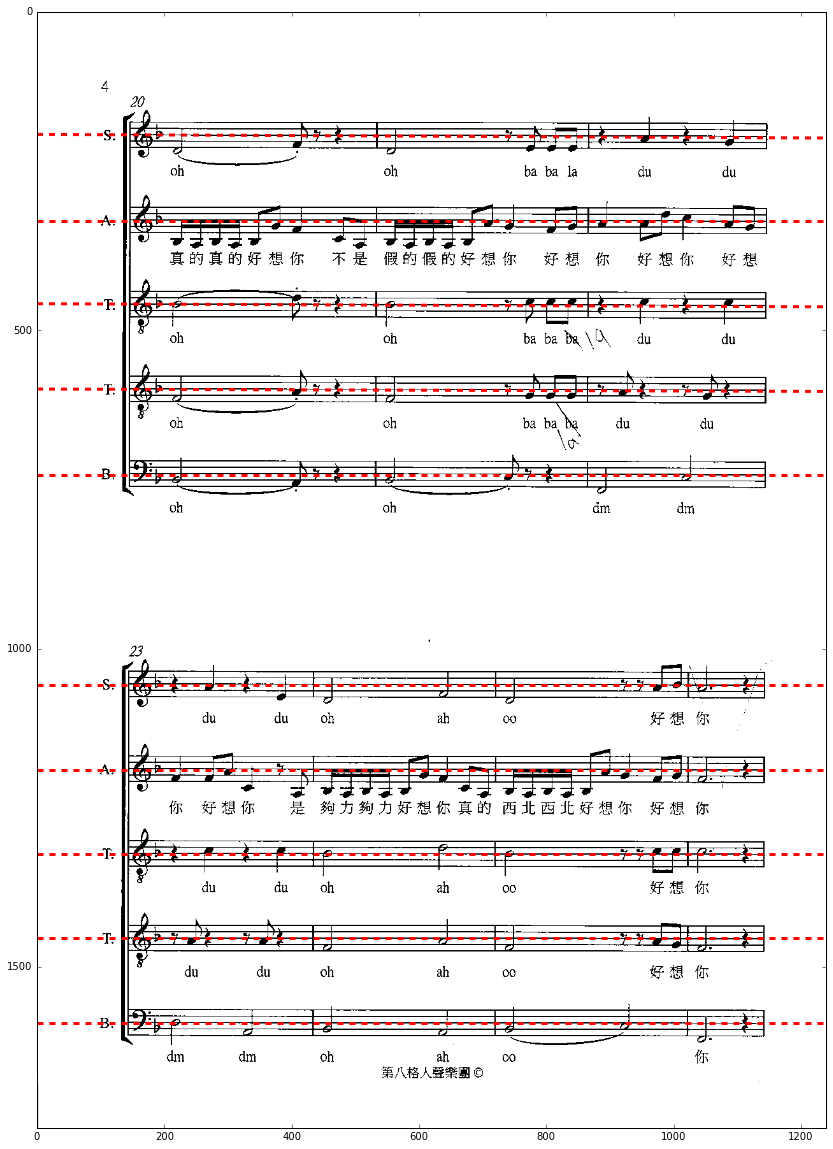

In [8]:
# Plot detected lines
xx = np.linspace(0, data.shape[1])
for slope, intercept in staff_center_lines:
    plt.plot(xx, slope*xx+intercept, "r--", linewidth=3)
plt.imshow(data, cmap=plt.cm.binary)
show(scale=5)

## 使用 `ScoreAnalyzer.image.imagetools` 來切割圖片

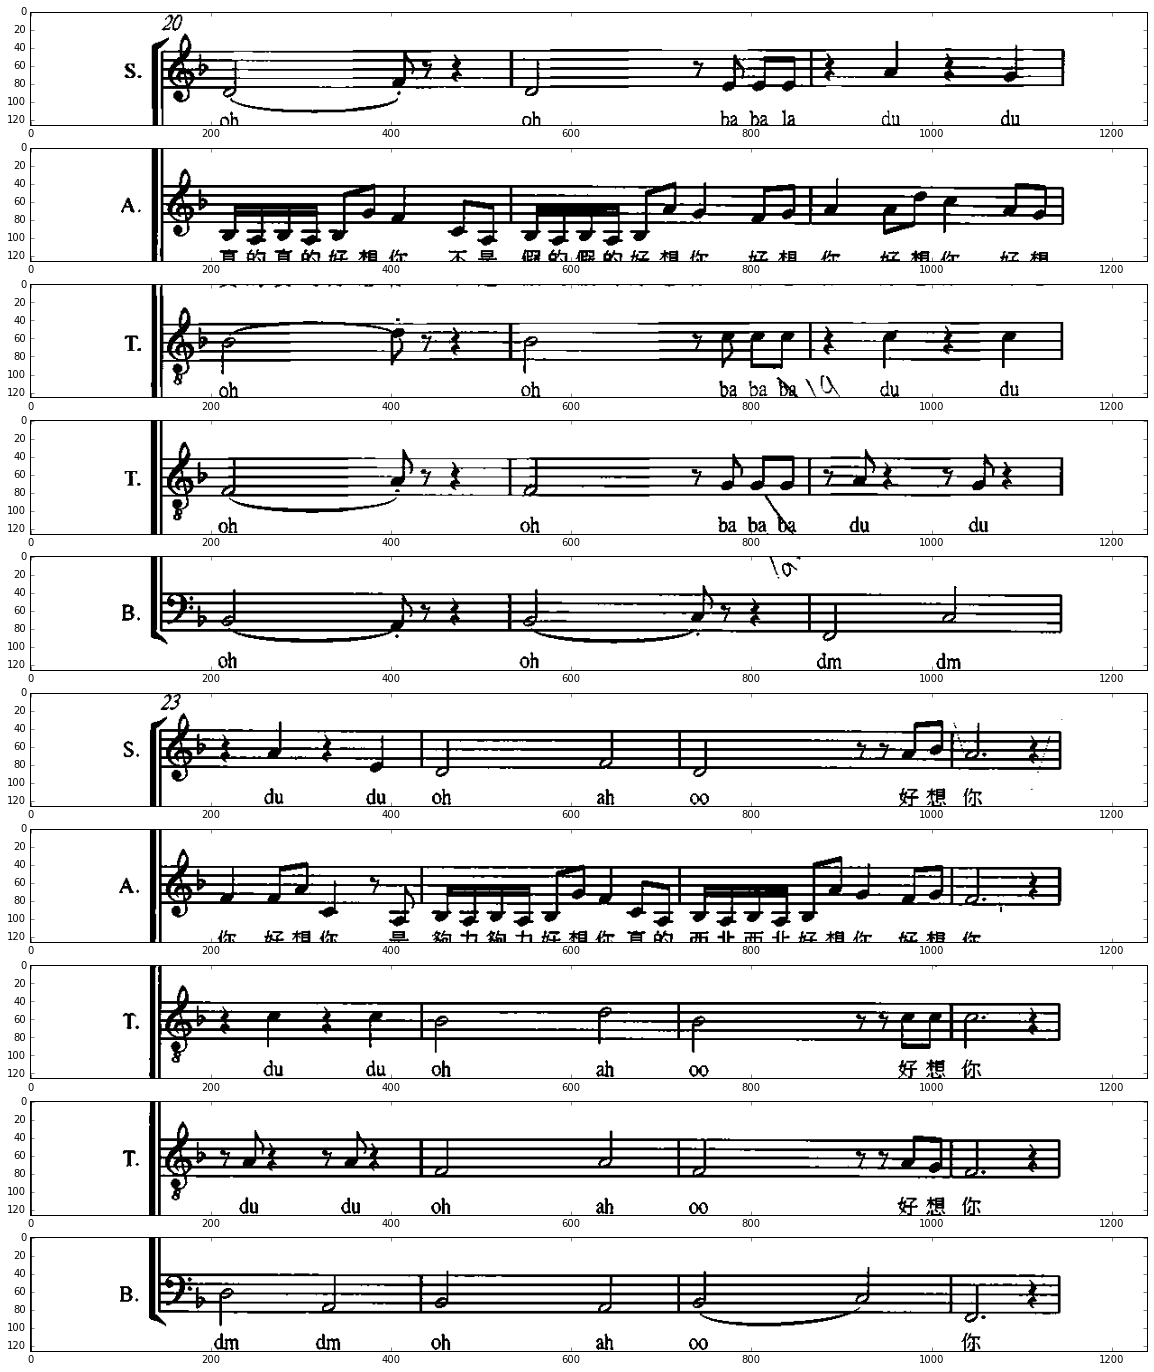

In [9]:
# it.segment_data(data, lines_params, margin, bin_thresh, deskew):
#   - data        : 圖片矩陣
#   - lines_params: 多條線方程式的陣列
#   - margin      : 以每條線為中心點上下延伸的切割垂直長度
#   - bin_thresh  : 再次二元化所需要的閾值
#   - derotate    : 是否要根據不同的線進行轉正
staff_images = it.segment_data(data=data, lines_params=staff_center_lines, margin=height*1.5, bin_thresh=.3, derotate=True)

if len(staff_images) > 1:
    f, axes = plt.subplots(len(staff_images), 1)
    for i, staff_image in enumerate(staff_images):
        axes[i].imshow(staff_image, cmap=plt.cm.binary)
else:
    plt.imshow(staff_images[0], cmap=plt.cm.binary)
show(scale=6)

## 使用 `ScoreAnalyzer.staffline.extractor` 將五線譜與五線分離

原圖


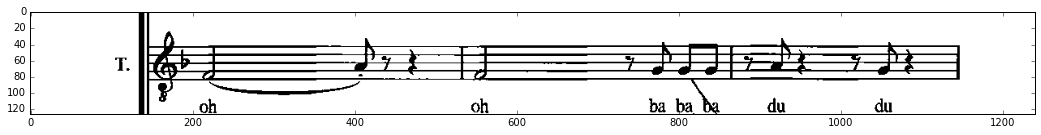

沒有五線


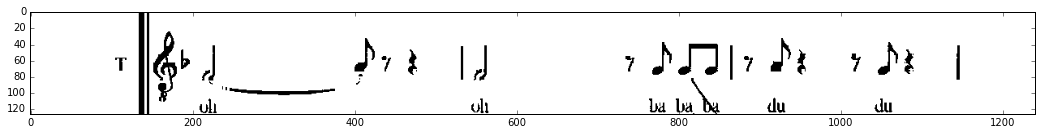

只有五線


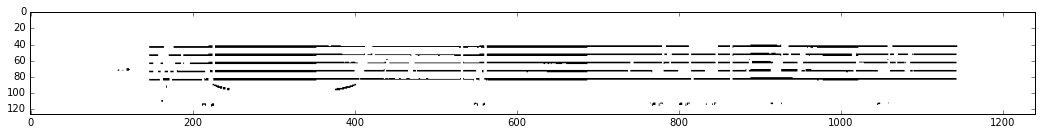

ypos: [43 53 63 73 83]


In [10]:
from ScoreAnalyzer.staffline import extractor as stfext

# Filter images that do not contain staff
staff_images = filter(lambda x: stfext.has_staffline(x, info["width"], info["space"]), staff_images)
# Choose an image with single staff
staff_image = staff_images[3]

# stfext.extract_staffline(data, width, space, num_lines):
#   - data     : 單一五線樂句的圖片
#   - width    : 線寬
#   - space    : 線距
#   - num_lines: 要抽幾條線出來（預設為5）
# returns:
#   - staff    : 只有五線的圖片
#   - symb     : 沒有五線的圖片
#   - ypos     : 五線被去除的y座標（只有主要的五條）
symb, staff, ypos = stfext.extract_staffline(staff_image, info["width"], info["space"], num_lines=11)

print "原圖"
plt.imshow(staff_image, cmap=plt.cm.binary)
show(scale=3)

print "沒有五線"
plt.imshow(symb, cmap=plt.cm.binary)
show(scale=3)

print "只有五線"
plt.imshow(staff, cmap=plt.cm.binary)
show(scale=3)
print "ypos: {}".format(ypos)

## 使用 `ScoreAnalyzer.detector.utils` 來偵測小節線

原圖


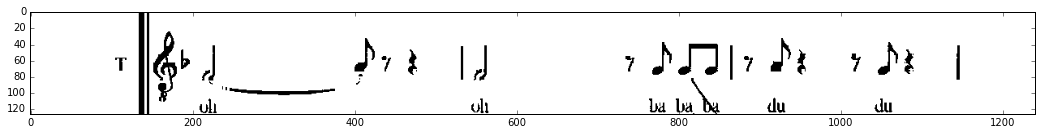

切割後


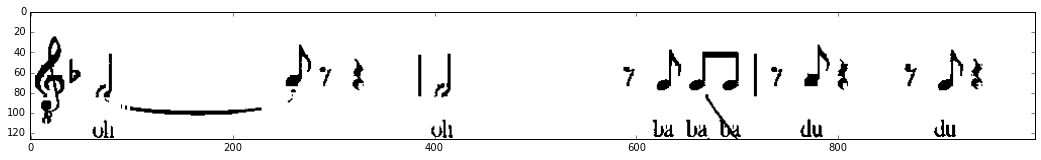

In [11]:
from ScoreAnalyzer.detector.utils import get_barline_positions, staff_tighten

# staff_tighten(symb, staff, bound_thresh):
#   - symb        : 沒有五線的圖片
#   - staff       : 只有五線的圖片
#   - bound_thresh: 判斷是否為邊界的閾值
# 附註：這個函式用來清除原本樂句圖片的兩側多餘空間
symb_t = staff_tighten(symb, staff, 4*info["width"])

print "原圖"
plt.imshow(symb, cmap=plt.cm.binary)
show(scale=3)
print "切割後"
plt.imshow(symb_t, cmap=plt.cm.binary)
show(scale=3)

[01] (384, 387)
[02] (716, 719)


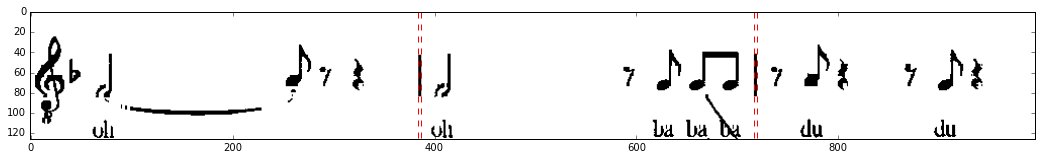

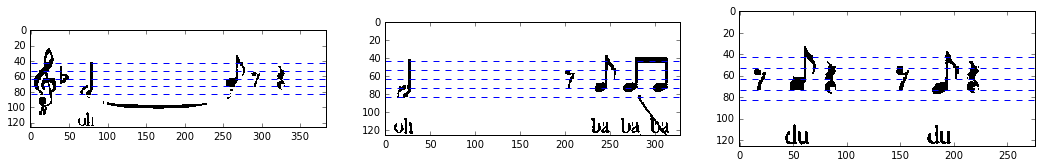

In [12]:
# get_barline_positions(data, info):
#   - data: 沒有五線的圖片
#   - info: 之前得到的五線資訊
# returns:
#   - (min_x, max_x)的陣列
barlines = get_barline_positions(data=symb_t, info=info)

# 將小節線的範圍畫出來
for i, bpos in enumerate(barlines):
    min_x, max_x = bpos
    plt.plot([min_x, min_x], [0, symb_t.shape[0]-1], "r--", linewidth=1)
    plt.plot([max_x, max_x], [0, symb_t.shape[0]-1], "r--", linewidth=1)
    print "[{:02d}] ({}, {})".format(i+1, min_x, max_x)
plt.imshow(symb_t, cmap=plt.cm.binary)
show(scale=3)

# 將圖片再次切割為每一個小節一張圖
regions = [0] + barlines.flatten().tolist() + [symb_t.shape[1]]
regions = np.reshape(regions, [len(regions)/2, 2])
measure_images = map(lambda x: symb_t[:, x[0]:x[1]], regions)

f, axes = plt.subplots(1, len(measure_images))
for i, measure_image in enumerate(measure_images):
    c = measure_image.shape[0]/2
    for si in range(-2, 3):
        y = c + si*(info["width"]+info["space"])
        axes[i].plot([0, measure_image.shape[1]-1], [y, y], "b--")
    axes[i].imshow(measure_image, cmap=plt.cm.binary, interpolation="nearest")
show(scale=3)

## 使用 `ScoreAnalyzer.detector.symbdetector` 偵測符號

In [13]:
from ScoreAnalyzer.detector.symbdetector import SymbolDetector

symbdtr = SymbolDetector(stfwidth=info["width"], stfspace=info["space"])

In [14]:
measure_image = measure_images[0]

# 找高音譜/低音譜記號
clefs = symbdtr.find_clefs(measure_image)

print "原始格式"
print clefs

margin = clefs["margin"]

# 將其轉變為矩陣格式
# 附註：每一列為一個被偵測資訊，其值意義為[符號ID, 判斷信心值, minx, maxx, miny, maxy]
clefs = SymbolDetector.to_matrix(clef_matched=clefs)

print "矩陣格式"
print clefs

原始格式
{'treble': array([[ nan,   5.,  34.]]), 'margin': 10, 'y-center': 63}
矩陣格式
[[  1.  nan   5.  34.  28.  98.]]


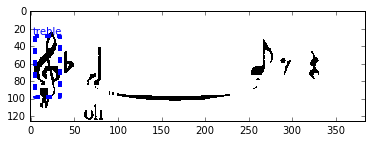

In [15]:
# 將偵測到的符號區塊畫出來
for symbid, conf, minx, maxx, miny, maxy in clefs:
    draw_rect([minx, miny], [maxx, maxy], "b--")
    plt.annotate(SymbolDetector.SYMBID_TO_SYMB[symbid], xy=((minx+maxx)/2, miny-margin/2),
                 horizontalalignment="center", 
                 verticalalignment="center",
                 color="b")

plt.imshow(measure_image, cmap=plt.cm.binary, interpolation="nearest")
show(scale=1)

## 使用 `ScoreAnalyzer.detector.stemdetector/beamgrouper` 找出符桿

In [16]:
from ScoreAnalyzer.detector.stemdetector import StemDetector
from ScoreAnalyzer.detector.beamgrouper import BeamGrouper

measure_image = measure_images[1]

# 偵測符桿
stems = StemDetector(info=info).find_stems(measure_image)[0]

print stems

[[ 26  28  42  81]
 [245 246  38  74]
 [278 280  40  75]
 [311 313  40  75]]


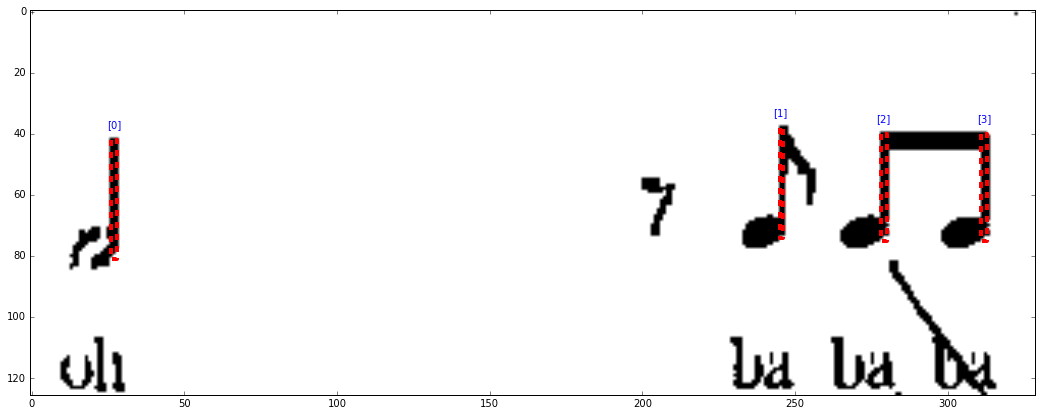

In [17]:
# 將符桿畫出來
for i, stem in enumerate(stems):
    minx, maxx, miny, maxy = stem
    draw_rect([minx, miny], [maxx, maxy], "r--")
    plt.annotate("[{}]".format(i), xy=((minx+maxx)/2, miny-margin/2),
                 horizontalalignment="center", 
                 verticalalignment="center",
                 color="b")

plt.imshow(measure_image, cmap=plt.cm.binary)
show(scale=3)

符桿[2]到符桿[3]為一個群組，符桿朝上


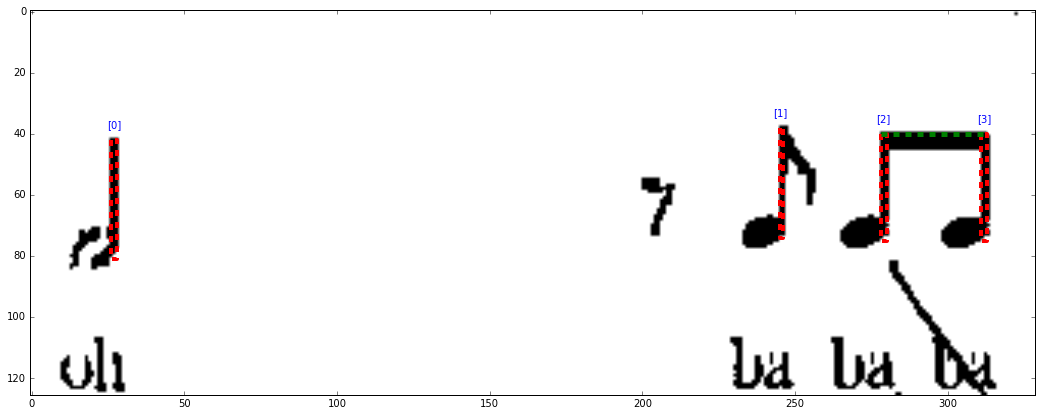

In [18]:
bg = BeamGrouper(img=measure_image, info=info, stems=stems)

for minid, maxid, updown in bg.beams:
    print "符桿[{}]到符桿[{}]為一個群組，符桿朝{}".format(minid, maxid, "上" if updown == 0 else "下")
    
# 將符桿畫出來
for i, stem in enumerate(bg.stems):
    minx, maxx, miny, maxy = stem
    draw_rect([minx, miny], [maxx, maxy], "r--")
    plt.annotate("[{}]".format(i), xy=((minx+maxx)/2, miny-margin/2),
                 horizontalalignment="center", 
                 verticalalignment="center",
                 color="b")

# 將beams畫出來
for minid, maxid, updown in bg.beams:
    lstem, rstem = bg.stems[minid], bg.stems[maxid]
    lx, ly, rx, ry = lstem[0], lstem[updown+2], rstem[1], rstem[updown+2]
    plt.plot([lx, rx], [ly, ry], "g--", linewidth=5)

plt.imshow(measure_image, cmap=plt.cm.binary)
show(scale=3)

## 利用找到的符桿來找符頭

In [19]:
nhs = symbdtr.find_noteheads_stem_guided(measure_image, beamgroup=bg)

print "原始格式"
print nhs

yc = nhs["y-center"]
margin = nhs["margin"]

print "\n-----------------------------------------------------------------------------------------------------------\n"

# 將其轉變為矩陣格式
# 附註：每一列為一個被偵測資訊，其值意義為[符號ID, 判斷信心值, minx, maxx, miny, maxy]
nhs = SymbolDetector.to_matrix(notehead_matched=nhs)

print "矩陣格式"
print nhs

原始格式
{'margin': 10, -3: {'nh-w': array([[  1.33310086,  14.        ,  28.        ]])}, -2: {'nh-b': array([[   1.53634181,  233.        ,  246.        ],
       [   1.37135884,  266.        ,  280.        ],
       [   1.17606708,  299.        ,  313.        ]])}, 'y-center': 63}

-----------------------------------------------------------------------------------------------------------

矩陣格式
[[  14.            1.33310086   14.           28.           70.           86.        ]
 [  13.            1.53634181  233.          246.           66.           80.        ]
 [  13.            1.37135884  266.          280.           66.           80.        ]
 [  13.            1.17606708  299.          313.           66.           80.        ]]


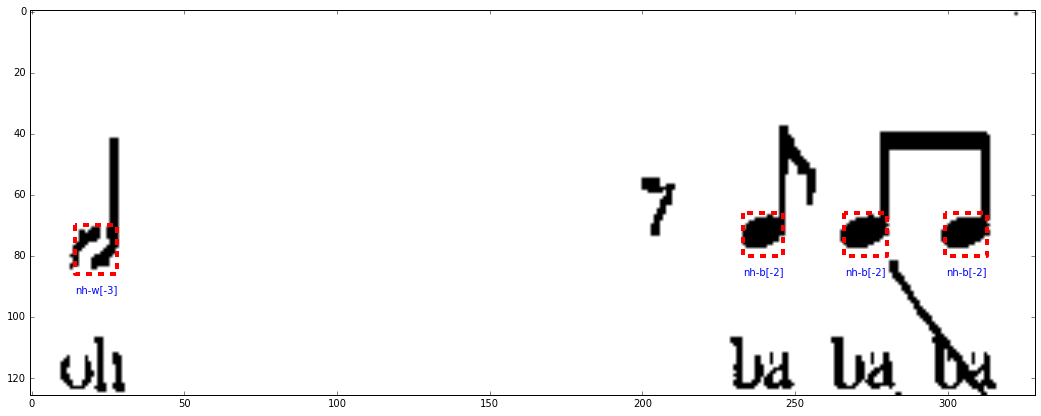

In [20]:
from ScoreAnalyzer.detector.utils import ypos_to_pitch_number

# 將偵測到的符頭標記出來
for symbid, conf, minx, maxx, miny, maxy in nhs:
    pi = ypos_to_pitch_number((miny+maxy)/2, yc, margin)
    draw_rect([minx, miny], [maxx, maxy], "r--")
    plt.annotate("{}[{}]".format(symbdtr.SYMBID_TO_SYMB[symbid], pi), xy=((minx+maxx)/2, maxy+margin/2),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="b")

plt.imshow(measure_image, cmap=plt.cm.binary)
show(scale=3)

## 搜尋休止符

In [21]:
measure_image = measure_images[0]
rests = symbdtr.find_rests(measure_image)

print "原始格式"
print rests

print "\n-----------------------------------------------------------------------------------------------------------\n"

rests = SymbolDetector.to_matrix(rest_matched=rests)

print "矩陣格式"
print rests

原始格式
{'rest08': array([[   0.70932525,  286.        ,  298.        ]]), 'y-center': 63, 'rest04': array([[   0.78900961,  319.        ,  331.        ]]), 'margin': 10}

-----------------------------------------------------------------------------------------------------------

矩陣格式
[[   9.            0.70932525  286.          298.           33.           83.        ]
 [   8.            0.78900961  319.          331.           33.           83.        ]]


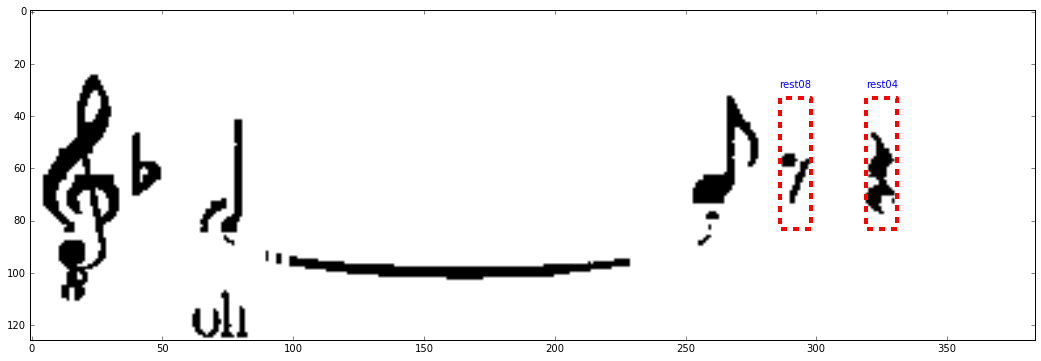

In [22]:
# 將偵測到的休止符標記出來
for symbid, conf, minx, maxx, miny, maxy in rests:
    draw_rect([minx, miny], [maxx, maxy], "r--")
    plt.annotate(symbdtr.SYMBID_TO_SYMB[symbid], xy=((minx+maxx)/2, miny-margin/2),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="b")

plt.imshow(measure_image, cmap=plt.cm.binary)
show(scale=3)

## 找尋升降記號

In [23]:
measure_image = measure_images[0]
accs = symbdtr.find_accidentals(measure_image, pitch_range=10)

print "原始格式"
print accs

print "\n-----------------------------------------------------------------------------------------------------------\n"

accs = SymbolDetector.to_matrix(acc_matched=accs)

print "矩陣格式"
print accs

原始格式
{0: {'flat': array([[  0.79438746,  40.        ,  48.        ]])}, 'y-center': 63, 'margin': 10}

-----------------------------------------------------------------------------------------------------------

矩陣格式
[[  3.           0.79438746  40.          48.          48.          78.        ]]


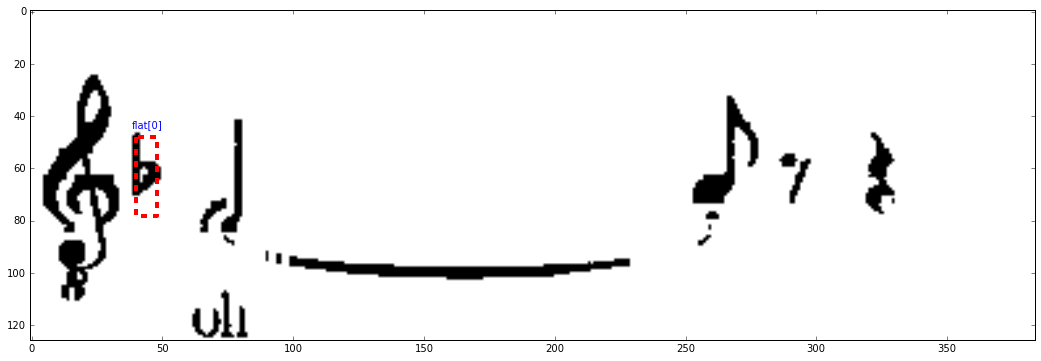

In [24]:
# 將偵測到的升降記號標記出來
for symbid, conf, minx, maxx, miny, maxy in accs:
    pi = ypos_to_pitch_number((miny+maxy)/2, yc, margin)
    draw_rect([minx, miny], [maxx, maxy], "r--")
    plt.annotate("{}[{}]".format(symbdtr.SYMBID_TO_SYMB[symbid], pi), xy=((minx+maxx)/2, miny-margin/2),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="b")
    
plt.imshow(measure_image, cmap=plt.cm.binary)
show(scale=3)